In [97]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from LIM import LIM_class
from LIM import utils as ut
plt.style.use("../plotting.mplstyle")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
data = xr.open_dataset("./data/ts_Amon_CESM2_piControl_r1i1p1f1.nc")["ts"]
#data = xr.open_dataset("./data/zos_Amon_CESM2_piControl_r1i1p1f1.nc")["zos"]
#data_old = xr.open_dataset("./data/ssta_1950_2021.nc")["ssta"]
mask = xr.open_dataset("./data/sftlf_fx_CESM2_historical_r1i1p1f1.nc")["sftlf"]

#14400 orginial size
data = data[:, :, :]

data = ut.apply_mask(mask, data)
#print("Data : {} + shape {}".format(data, data.shape))

data_anomalies = ut.calculate_monthly_anomalies(data)
#print("Month mean : {} + shape : {}".format(data_anomalies, data_anomalies.shape))

data_cropped =ut.crop_xarray(data_anomalies)
#print("Data cropped : {} + shape : {}".format(data_cropped, data_cropped.shape))


pca_10 = ut.SpatioTemporalPCA(data_cropped, n_components=20)
#pca_10 = ut.SpatioTemporalPCA(data_anomalies, n_components=20)
eof_10 = pca_10.eofs()
pc_10 = pca_10.principal_components()

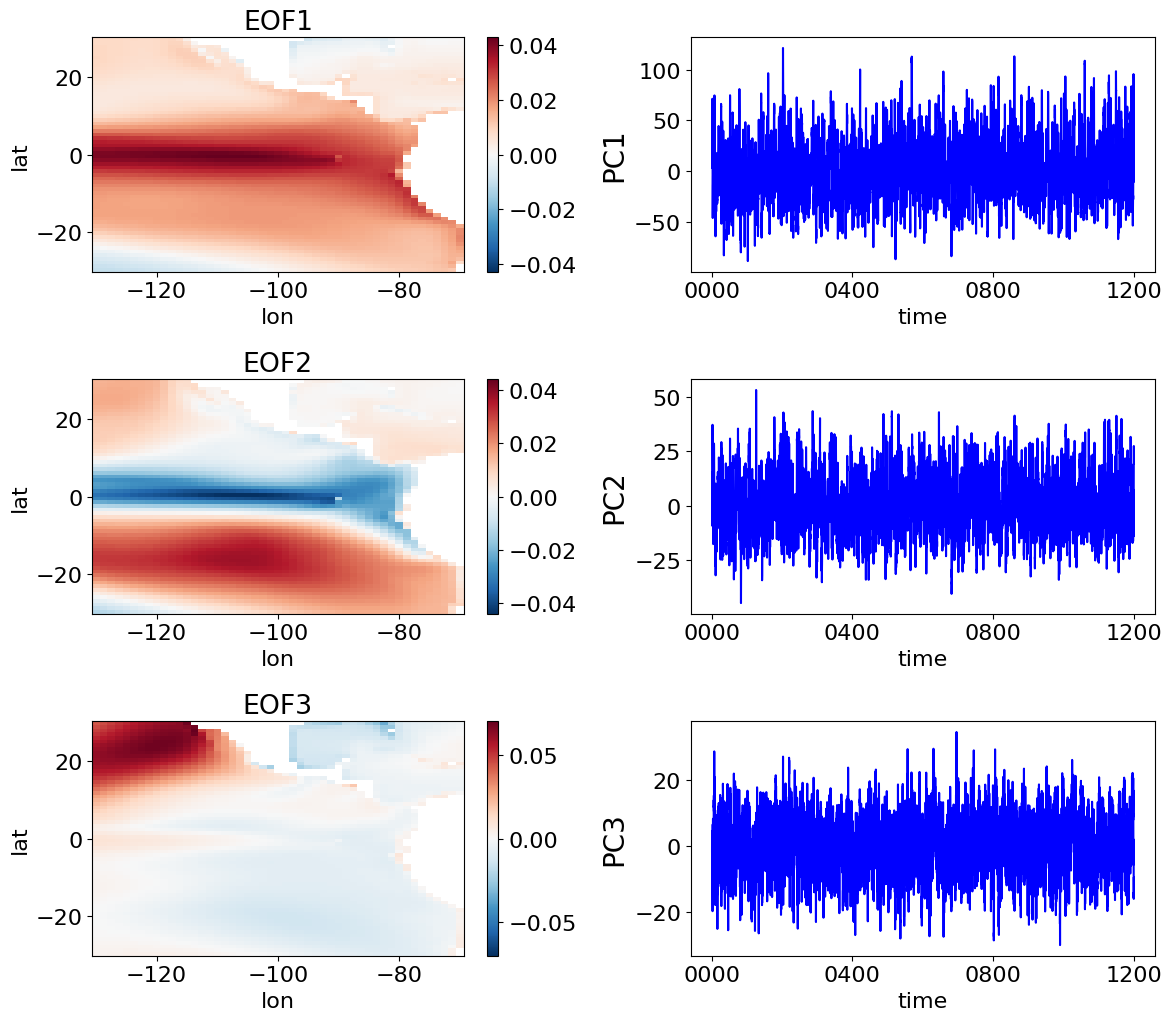

In [99]:
# Set the number of plots to 2
number_of_plots = 3

# Create the figure and axes objects
fig = plt.figure(figsize=(2 * 6, 3.5 * number_of_plots))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    ax = fig.add_subplot(number_of_plots, 2, 2*i+1)
    eof_10[i].plot(ax=ax, cmap="RdBu_r")
    ax.set_title(f"EOF{i+1}")
    ax = fig.add_subplot(number_of_plots, 2, 2*i + 2)
    pc_10.isel(eof=i).plot(ax=ax, color="blue")
    ax.set_ylabel(f"PC{i+1}", fontsize=20)

# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)
fig.savefig('./plots/svg/EOFS_timeseries_piControl.svg', format='svg')
fig.savefig('./plots/png/EOFS_timeseries_piControl.png', format='png')
plt.show()

In [100]:
# Create training and test data

data = pca_10.principal_components()
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]
data_test = data[:, index_train:]
# Creating an example LIM object

tau = 1
model = LIM_class.LIM(tau)
model.fit(data_train.data)

eigenvalues, _, _ = ut.matrix_decomposition(model.green_function)
t_decay = [abs(-(1/np.log(eigenvalue.real))) for eigenvalue in eigenvalues]

print("Eigenvalues : min {} + max {}".format(min(eigenvalues), max(eigenvalues)))
print("T-decay : min {} + max {}".format(min(t_decay), max(t_decay)))
#print("Data train : {} + shape: {}".format(data_train.data, data_train.data.shape))

Covariance matrix has negative values!
Eigenvalues : min (0.3445316255092621-0.14244022965431213j) + max (0.9229917526245117+0j)
T-decay : min 0.9384653869199847 + max 12.478944840958633


In [101]:
# Simulate stochastic differential equation
x_input = data_train.isel(time=0)
times = x_input['time']
x = x_input.data

lim_integration, times_ = model.noise_integration(x, timesteps=499, seed=10, num_comp=len(pc_10))

lim_integration = lim_integration.T
pc_10 = np.array(pc_10)
#print("LIMMM : {} + next {} + next {}".format(lim_integration[0][:5], lim_integration[0][50], lim_integration[0][-3:]))
#print("PCCC : {} + next {} + next {}".format(pc_10[0][:5], pc_10[0][50], pc_10[0][-3:] ))

t_delta = 0.9384653869199847
t_delta perc : 0.32846288542199464
t_delta = 0.6100025014979901
LIMMM : [ 3.08271694  1.67446114 13.88820011 11.88124336 29.32695525] + next -31.27315063651613 + next [  5.39252958 -13.28571784 -33.03625417]
PCCC : [ 3.082717   7.5887194 11.522211  20.290155  27.013723 ] + next 50.62574005126953 + next [  2.111078   -2.2536316 -10.422924 ]


In [102]:
# # Set the number of plots to 2
# number_of_plots = 3
# # Create the figure and axes objects
# fig, axs = plt.subplots(number_of_plots, 2, figsize=(20, 65))
#
# # Set titles and plot the contourf and plot for each EOF and PC
# for i in range(number_of_plots):
#     axs[i,1].set_title("PC - integrated {}".format(i + 1), fontsize=30)
#     # Define time variable
#     time = np.arange(len(pc_10[i]))
#     # Convert time to years
#     time_years = time/12 + 1950
#
#     # Plot PC with time on x-axis in years
#     axs[i,0].plot(time_years, pc_10[i][:500])
#     axs[i,0].set_xlabel("Time (years)", fontsize=25)
#
#     # Plot PC with time on x-axis in years for integrated data
#     axs[i,1].plot(time_years, lim_integration[i])
#     axs[i,1].set_xlabel("Time (years)", fontsize=25)
#
#
#
# plt.legend(loc="upper right", fontsize=20)
# # Add padding between subplots and adjust layout
# fig.tight_layout(pad=2)
# #fig.savefig('./plots/svg/EOFS_timeseries_RdBu_r_piControl_.svg', format='svg')
# #fig.savefig('./plots/png/EOFS_timeseries_RdBu_r_piControl_.png', format='png')
# #plt.show()

In [103]:
# Create training and test data

data = pca_10.principal_components()
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]

eps = 0.01

# original fit
tau = 1
model = LIM_class.LIM(tau)
model.fit(data_train.data, eps=eps)

logar_matr = model.logarithmic_matrix
noise_matr = model.noise_covariance


# Get input data
x_input = data_test.isel(time=0)
x_input = x_input.data

# Forecast mean using LIM model
lim_integration1, times_ = model.noise_integration(x_input, timesteps=1000, num_comp=len(pc_10))
lim_integration1 = lim_integration1.T

lim_integration2, times_ = model.noise_integration(x_input, timesteps=10000, num_comp=len(pc_10))
lim_integration2 = lim_integration2.T

lim_integration3, times_ = model.noise_integration(x_input, timesteps=100000, num_comp=len(pc_10))
lim_integration3 = lim_integration3.T

tau = 1
model1 = LIM_class.LIM(tau)
model1.fit(lim_integration1, eps=eps)

logar_matr1 = model1.logarithmic_matrix
noise_matr1 = model1.noise_covariance

model2 = LIM_class.LIM(tau)
model2.fit(lim_integration2, eps=eps)

logar_matr2 = model2.logarithmic_matrix
noise_matr2 = model2.noise_covariance

model3 = LIM_class.LIM(tau)
model3.fit(lim_integration3, eps=eps)

logar_matr3 = model3.logarithmic_matrix
noise_matr3 = model3.noise_covariance

Covariance matrix has negative values!
t_delta = 0.9384653869199847
t_delta perc : 0.32846288542199464
t_delta = 0.6100025014979901
t_delta = 0.9384653869199847
t_delta perc : 0.32846288542199464
t_delta = 0.6100025014979901
t_delta = 0.9384653869199847
t_delta perc : 0.32846288542199464
t_delta = 0.6100025014979901
Covariance matrix has negative values!
Covariance matrix has negative values!
Covariance matrix has negative values!


G_min : [-0.36069906, -0.4809170794807628]
G_max : [0.9680434, 0.9672833993376503]
L_min : [-0.74270356, -0.9999614686222313]
L_max : [0.6685341, 0.9979045888459073]
Q_min : [-5.3703117, -5.630680037255095]
Q_max : [36.396736, 29.890208932207845]


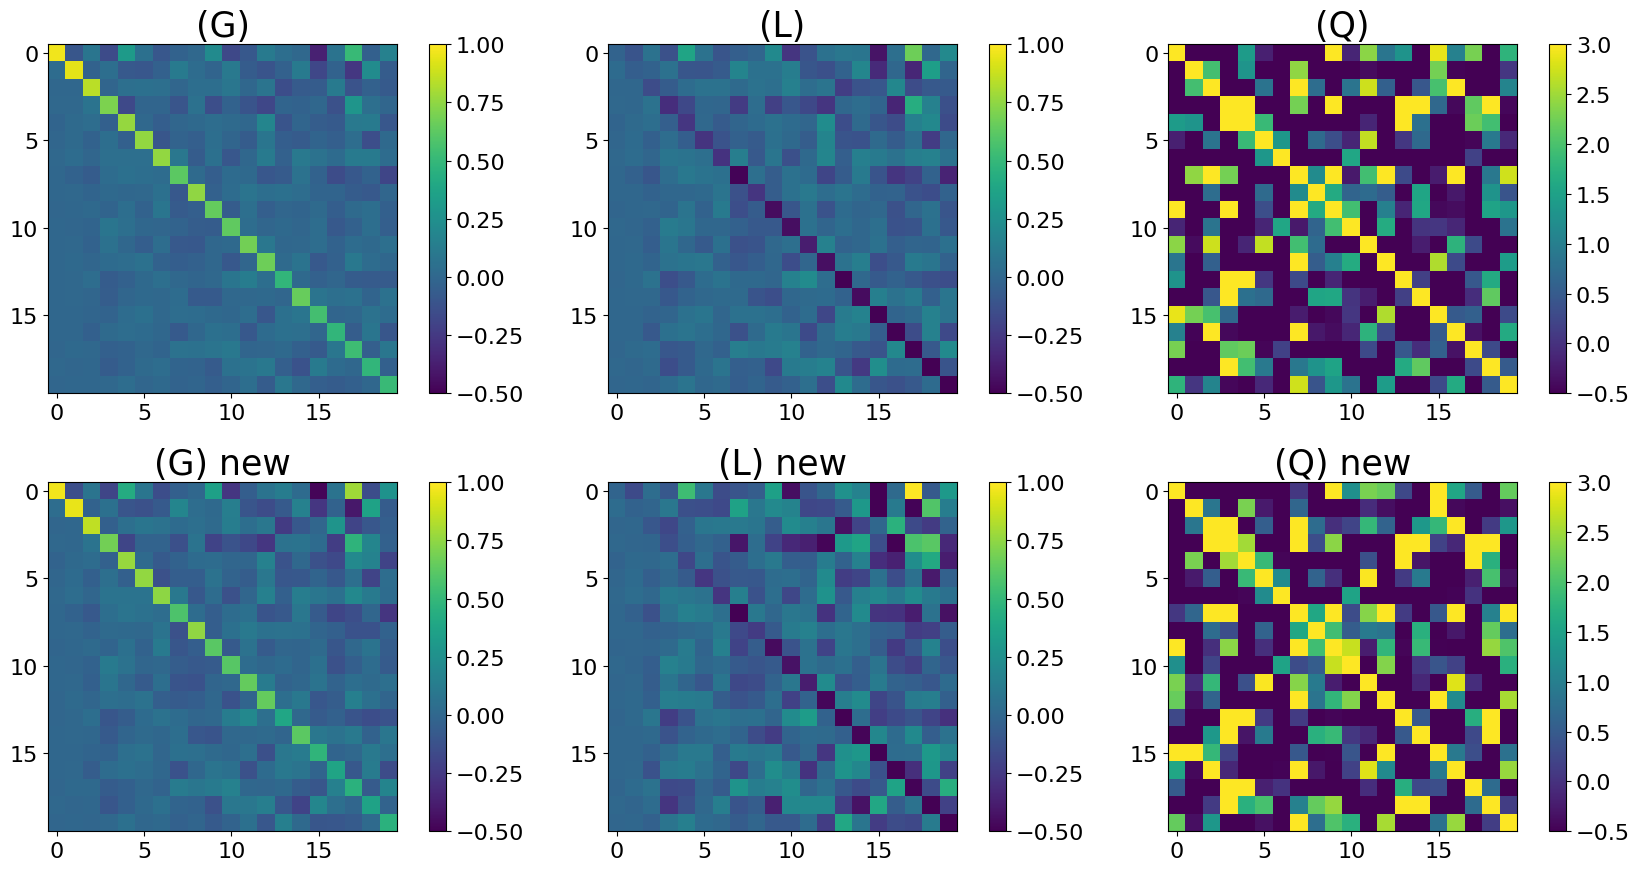

In [104]:
# Plot G, L, Q
fig, axs = plt.subplots(2, 3, figsize=(18, 9))

# Plot G
im1 = axs[0][0].imshow(model.green_function, vmin=-0.5, vmax=1)
#im1 = axs[0][0].imshow(model.green_function)
axs[0][0].set_title('(G)', fontsize=25)
fig.colorbar(im1, ax=axs[0][0])
im11 = axs[1][0].imshow(model2.green_function, vmin=-0.5, vmax=1)
#im11 = axs[1][0].imshow(model2.green_function)
axs[1][0].set_title('(G) new', fontsize=25)
fig.colorbar(im11, ax=axs[1][0])

g_min = [np.min(model.green_function), np.min(model2.green_function)]
g_max = [np.max(model.green_function), np.max(model2.green_function)]
print("G_min : {}".format(g_min))
print("G_max : {}".format(g_max))

# Plot L
im2 = axs[0][1].imshow(np.real(model.logarithmic_matrix), vmin=-0.5, vmax=1)
#im2 = axs[0][1].imshow(np.real(model.logarithmic_matrix))
axs[0][1].set_title('(L)', fontsize=25)
fig.colorbar(im2, ax=axs[0][1])
im21 = axs[1][1].imshow(np.real(model2.logarithmic_matrix), vmin=-0.5, vmax=1)
#im21 = axs[1][1].imshow(np.real(model2.logarithmic_matrix))
axs[1][1].set_title('(L) new', fontsize=25)
fig.colorbar(im21, ax=axs[1][1])

l_min = [np.min(np.real(model.logarithmic_matrix)), np.min(np.real(model2.logarithmic_matrix))]
l_max = [np.max(np.real(model.logarithmic_matrix)), np.max(np.real(model2.logarithmic_matrix))]
print("L_min : {}".format(l_min))
print("L_max : {}".format(l_max))


# Plot Q
im3 = axs[0][2].imshow(np.real(model.noise_covariance), vmin=-0.5, vmax=3)
#im3 = axs[0][2].imshow(np.real(model.noise_covariance))
axs[0][2].set_title('(Q)', fontsize=25)
fig.colorbar(im3, ax=axs[0][2])
im31 = axs[1][2].imshow(np.real(model2.noise_covariance), vmin=-0.5, vmax=3)
#im31 = axs[1][2].imshow(np.real(model2.noise_covariance))
axs[1][2].set_title('(Q) new', fontsize=25)
fig.colorbar(im31, ax=axs[1][2])

q_min = [np.min(np.real(model.noise_covariance)), np.min(np.real(model2.noise_covariance))]
q_max = [np.max(np.real(model.noise_covariance)), np.max(np.real(model2.noise_covariance))]
print("Q_min : {}".format(q_min))
print("Q_max : {}".format(q_max))

plt.tight_layout()
fig.savefig('./plots/svg/G_Q_L_function_piControl.svg', format='svg')
fig.savefig('./plots/png/G_Q_L_function_piControl.png', format='png')
plt.show()

C:\Users\felix\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


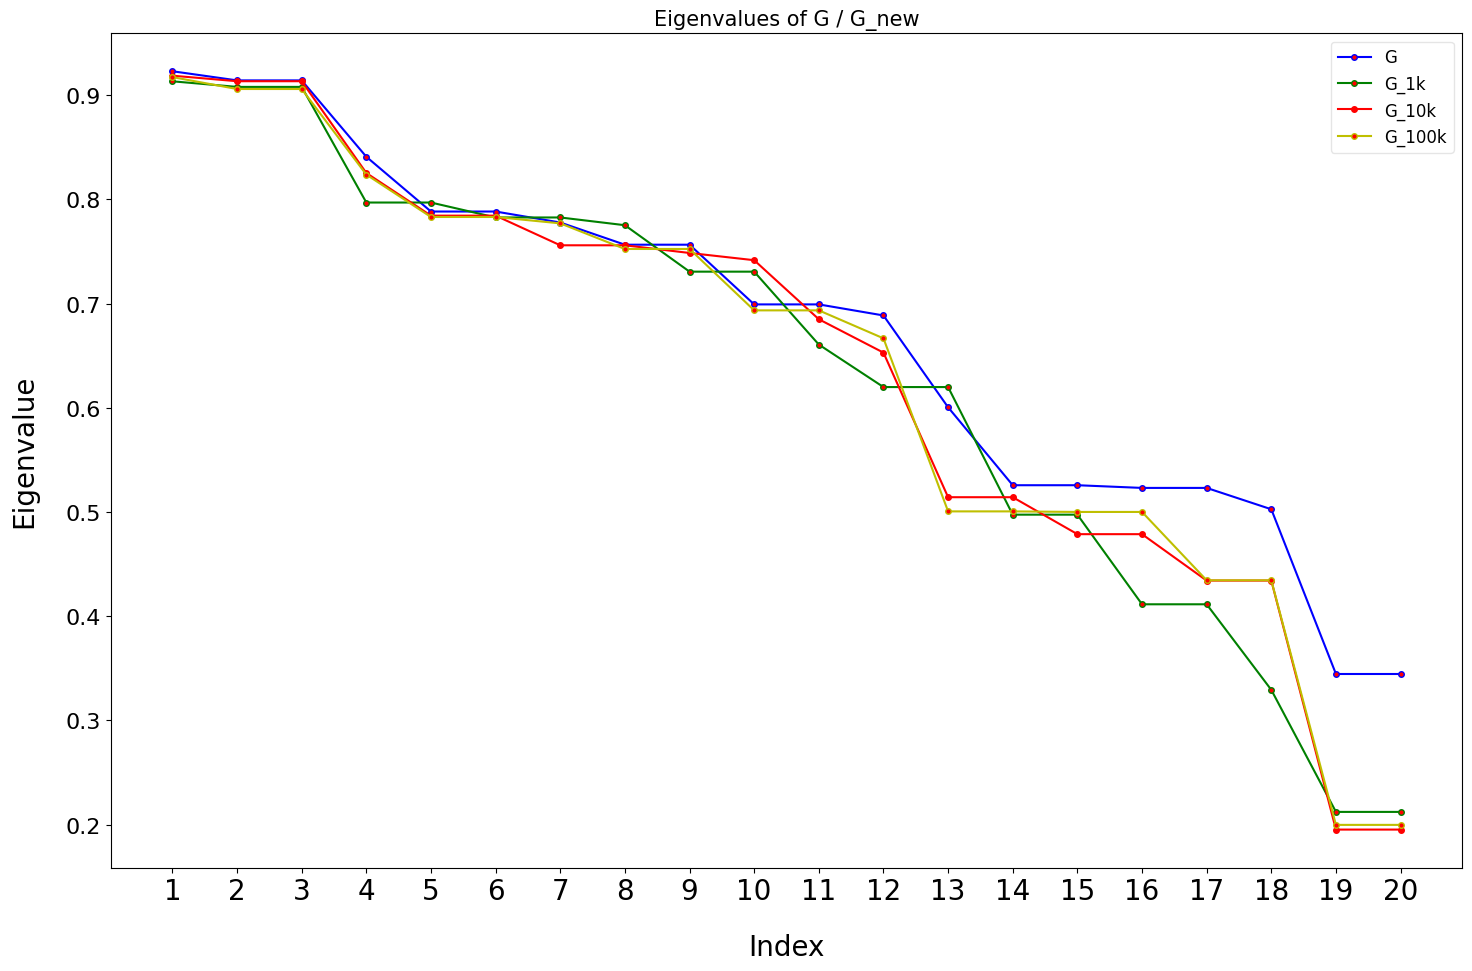

In [105]:
# Plotting eigenvalues of G
eigenvalues, _, w = ut.matrix_decomposition(model.green_function)
eigenvalues1, _, w = ut.matrix_decomposition(model1.green_function)
eigenvalues2, _, w = ut.matrix_decomposition(model2.green_function)
eigenvalues3, _, w = ut.matrix_decomposition(model3.green_function)


x = np.arange(1, len(eigenvalues) + 1)
plt.figure(figsize=(15,10))
# Plot the eigenvalues
plt.plot(x, eigenvalues, marker='o', linestyle='-', color='b', markersize=4, markerfacecolor='r', linewidth=1.5,
         label='G')
plt.plot(x, eigenvalues1, marker='o', linestyle='-', color='g', markersize=4, markerfacecolor='r', linewidth=1.5,
         label='G_1k')
plt.plot(x, eigenvalues2, marker='o', linestyle='-', color='r', markersize=4, markerfacecolor='r', linewidth=1.5,
         label='G_10k')
plt.plot(x, eigenvalues3, marker='o', linestyle='-', color='y', markersize=4, markerfacecolor='r', linewidth=1.5,
         label='G_100k')
# Set the labels and title
plt.xlabel('Index', fontsize=20, labelpad=20)
plt.ylabel('Eigenvalue', fontsize=20, labelpad=20)
plt.title('Eigenvalues of G / G_new', fontsize=15)

# Set the x-axis tick labels
plt.xticks(x, fontsize=20)
plt.legend(loc="upper right", fontsize=12)

# Display the plot
plt.savefig('./plots/svg/eigenvalues_G_combined_piControl.svg', format='svg')
plt.savefig('./plots/png/eigenvalues_G_combined_piControl.png', format='png')
plt.show()